In [10]:
import time  # Timing operations

# Import necessary libraries for numerical operations and data processing
import numpy as np  # Linear algebra operations, particularly with embeddings
import pandas as pd  # Data processing, including reading and manipulating CSV files

# Import text processing libraries
import re  # Regular expressions for text cleaning
import nltk  # Natural Language Toolkit for NLP tasks
from nltk.corpus import stopwords  # Stopwords corpus for removing common stopwords
from gensim.models import Word2Vec  # Gensim for Word2Vec embeddings

# Import classifier
from sklearn.neural_network import MLPClassifier  # Neural network-based classification

In [13]:
# Load the training and test datasets
import pandas as pd

train = pd.read_csv("C:\\Users\\anuli\\OneDrive\\Desktop\\Multi Label Absuive Comments Identification\\Datasets\\train.csv")  # Load the training data from CSV file
test = pd.read_csv("C:\\Users\\anuli\\OneDrive\\Desktop\\Multi Label Absuive Comments Identification\\Datasets\\test.csv")  # Load the test data from CSV file

# Copy the 'id' column from the test set for later use in submission
result = test[['id']].copy()

# Function to format each row for display
def format_row(row):
    formatted_comment = row['comment_text']
    labels = row[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_dict()
    formatted_labels = '\n'.join(f"{key}: {value}" for key, value in labels.items())
    return f"Comment: {formatted_comment}\nLabels:\n{formatted_labels}\n"

# Print the formatted rows
for index, row in train.head(3).iterrows():
    print(format_row(row))
    print('-' * 40)  # Separator line for readability

# Display the first 3 rows of the training set to get an initial impression of the data
print(train.head(3))

Comment: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Labels:
toxic: 0
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0

----------------------------------------
Comment: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Labels:
toxic: 0
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0

----------------------------------------
Comment: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Labels:
toxic: 0
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0

---------------------------------

In [14]:
# Count the number of instances for each severity label where the value is greater than 0
print('toxic: %d' % train[train['toxic'] > 0]['toxic'].count())
print('severe_toxic: %d' % train[train['severe_toxic'] > 0]['severe_toxic'].count())
print('obscene: %d' % train[train['obscene'] > 0]['obscene'].count())
print('threat: %d' % train[train['threat'] > 0]['threat'].count())
print('insult: %d' % train[train['insult'] > 0]['insult'].count())
print('identity_hate: %d' % train[train['identity_hate'] > 0]['identity_hate'].count())

toxic: 15294
severe_toxic: 1595
obscene: 8449
threat: 478
insult: 7877
identity_hate: 1405


In [15]:
# Count the number of instances where 'severe_toxic' is greater than 0 but 'toxic' is 0
print('Severe toxic but NOT toxic?: %d' % train[(train['severe_toxic'] > 0) & (train['toxic'] == 0)]['id'].count())

# Count the number of instances where 'insult' is greater than 0 but 'toxic' is 0
print('Insult but NOT toxic?: %d' % train[(train['insult'] > 0) & (train['toxic'] == 0)]['id'].count())

# Count the number of instances where 'obscene' is greater than 0 but 'toxic' is 0
print('Obscene but NOT toxic?: %d' % train[(train['obscene'] > 0) & (train['toxic'] == 0)]['id'].count())

# Count the number of instances where 'threat' is greater than 0 but 'insult' is 0
print('Threat but NOT insult?: %d' % train[(train['threat'] > 0) & (train['insult'] == 0)]['id'].count())

Severe toxic but NOT toxic?: 0
Insult but NOT toxic?: 533
Obscene but NOT toxic?: 523
Threat but NOT insult?: 171


In [16]:
# Add a new column 'len' that contains the length of each comment
train['len'] = train['comment_text'].str.len()

# Calculate and print the average length of comments
print('Average comment length: %d' % train['len'].mean())

# Calculate and print the median length of comments
print('Median comment length: %d' % train['len'].quantile(0.5))

# Calculate and print the 90th percentile length of comments
print('90th percentile comment length: %d' % train['len'].quantile(0.9))

Average comment length: 394
Median comment length: 205
90th percentile comment length: 889


In [18]:
# Print rows from the training set where 'comment_text' is null
print("Training set rows with null 'comment_text':")
print(train[train['comment_text'].isnull()])
print("\n")
# Print rows from the test set where 'comment_text' is null
print("Test set rows with null 'comment_text':")
print(test[test['comment_text'].isnull()])

Training set rows with null 'comment_text':
Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate, len]
Index: []


Test set rows with null 'comment_text':
Empty DataFrame
Columns: [id, comment_text]
Index: []


In [19]:
# Fill missing values in the 'comment_text' column of the test dataset with 'none'
test['comment_text'].fillna(value='none', inplace=True)

# Fill missing values in the 'comment_text' column of the training dataset with 'none'
train['comment_text'].fillna(value='none', inplace=True)

In [22]:
def text_to_words(raw_text, remove_stopwords=False):
    """
    Convert raw text into a list of words.
    
    Parameters:
    raw_text (str): The raw text to process.
    remove_stopwords (bool): Whether to remove common stopwords from the list of words.
    
    Returns:
    list: A list of words from the text.
    """
    # 1. Remove non-letters, but including numbers
    letters_only = re.sub(r"[^0-9a-zA-Z]", " ", raw_text)
    
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    if remove_stopwords:
        # Create a set of stopwords for faster lookup
        stops = set(stopwords.words("english"))
        # Remove stop words from the list of words
        meaningful_words = [w for w in words if w not in stops]
        words = meaningful_words
    
    return words

# Apply text_to_words function to 'comment_text' column in training and test datasets
sentences_train = train['comment_text'].apply(lambda x: text_to_words(x, remove_stopwords=False))
sentences_test = test['comment_text'].apply(lambda x: text_to_words(x, remove_stopwords=False))

# Show first three processed arrays as samples
print(sentences_train[:3])

0    [explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, reverted, they, weren, t, vandalisms, just, closure, on, some, gas, after, i, voted, at, new, york, dolls, fac, and, please, don, t, remove, the, template, from, the, talk, page, since, i, m, retired, now, 89, 205, 38, 27]
1                                                                                                                                                                                                 [d, aww, he, matches, this, background, colour, i, m, seemingly, stuck, with, thanks, talk, 21, 51, january, 11, 2016, utc]
2                                          [hey, man, i, m, really, not, trying, to, edit, war, it, s, just, that, this, guy, is, constantly, removing, relevant, information, and, talking, to, me, through, edits, instead, of, my, talk, page, he, seems, to, care, more, about, the, formatting, than, the, actual, info]
Name: comment_text, dtype: object


In [25]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [24]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

In [26]:
# Define and train the Word2Vec model with specified parameters
model = Word2Vec(sentences=sentences_train,
                  vector_size=num_features,
                  window=context,
                  min_count=min_word_count,
                  sample=downsampling,
                  workers=num_workers)

# Save the model's word vectors and discard the full model to save memory
word_vectors = model.wv
word_vectors.save("word_vectors.kv")

# Optionally, load these vectors without the full model
word_vectors = KeyedVectors.load("word_vectors.kv", mmap='r')

# Now you can use `word_vectors` for querying, which is memory efficient

In [27]:
def makeFeatureVec(words, model, num_features):
    # Initialize a zero vector to hold the feature values
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    # Convert model vocabulary to a set for faster word lookup
    index2word_set = set(model.index_to_key)  # Updated to use index_to_key
    # Sum vectors for words that are present in the model's vocabulary
    for word in words:
        if word in index2word_set:
            nwords += 1
            featureVec = np.add(featureVec, model[word])  # Updated to use model.wv[word]
    # Compute the average vector; avoid division by zero
    if nwords == 0:
        nwords = 1  # Avoid division by zero
    featureVec = np.divide(featureVec, nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    # Initialize a 2D array to store feature vectors for all reviews
    reviewFeatureVecs = np.zeros((len(reviews), num_features), dtype="float32")
    # Compute the average feature vector for each review
    for counter, review in enumerate(reviews):
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
    return reviewFeatureVecs 

In [28]:
# Load pre-trained word vectors
word_vectors = KeyedVectors.load("word_vectors.kv", mmap='r')

# Convert training and test sentences to feature vectors
f_matrix_train = getAvgFeatureVecs(sentences_train, word_vectors, num_features)
f_matrix_test = getAvgFeatureVecs(sentences_test, word_vectors, num_features)

# Prepare target labels for training 6 different models
y = [train['toxic'], train['severe_toxic'], train['obscene'], train['threat'], train['insult'], train['identity_hate']]

In [29]:
# Create a list to store 6 MLP models
model = []

# Initialize and append 6 MLPClassifier models to the list
for i in range(0, 6):
    # Create an MLP model with three hidden layers, each with 30 neurons
    m = MLPClassifier(solver='adam', hidden_layer_sizes=(30,30,30), random_state=1)
    model.append(m)

# Print the list of models
print(model)

[MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1), MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=1)]


In [30]:
batch_size = 10000  # Number of samples to process in each batch
total_rows = f_matrix_train.shape[0]  # Total number of training samples
duration = 0  # Time elapsed during training
start_train = time.time()  # Record the start time of training
pos = 0  # Initial position in the dataset
classes = [0, 1]  # Binary classes for classification

# Perform training using a partial fit approach
while duration < 2500 and pos < total_rows:
    for i in range(6):
        # Adjust batch size if the remaining samples are less than the batch size
        if pos + batch_size > total_rows:
            batch_size = total_rows - pos
        # Select a batch of training data and corresponding labels
        X_p = f_matrix_train[pos:pos + batch_size]
        y_p = y[i][pos:pos + batch_size]
        # Update the model with the current batch
        model[i].partial_fit(X_p, y_p, classes)
    pos += batch_size  # Move to the next batch
    duration = time.time() - start_train  # Update elapsed time
    print("Pos %d/%d duration %d" % (pos, total_rows, duration))  # Print progress

Pos 10000/159571 duration 0
Pos 20000/159571 duration 0
Pos 30000/159571 duration 1
Pos 40000/159571 duration 1
Pos 50000/159571 duration 2
Pos 60000/159571 duration 2
Pos 70000/159571 duration 2
Pos 80000/159571 duration 3
Pos 90000/159571 duration 3
Pos 100000/159571 duration 4
Pos 110000/159571 duration 4
Pos 120000/159571 duration 4
Pos 130000/159571 duration 5
Pos 140000/159571 duration 5
Pos 150000/159571 duration 6
Pos 159571/159571 duration 6


In [31]:
# Predict probabilities for each class using the trained models
result['toxic'] = model[0].predict_proba(f_matrix_test)[:, 1]         # Probability of 'toxic' class
result['severe_toxic'] = model[1].predict_proba(f_matrix_test)[:, 1] # Probability of 'severe_toxic' class
result['obscene'] = model[2].predict_proba(f_matrix_test)[:, 1]      # Probability of 'obscene' class
result['threat'] = model[3].predict_proba(f_matrix_test)[:, 1]       # Probability of 'threat' class
result['insult'] = model[4].predict_proba(f_matrix_test)[:, 1]       # Probability of 'insult' class
result['identity_hate'] = model[5].predict_proba(f_matrix_test)[:, 1] # Probability of 'identity_hate' class


In [32]:
# Save the results to a CSV file
result.to_csv('submission.csv', encoding='utf-8', index=False)

In [36]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Load your dataset
train_balanced = pd.read_csv('C:\\Users\\anuli\\OneDrive\\Desktop\\Multi Label Absuive Comments Identification\\Datasets\\train.csv')  # Adjust path as necessary

# Define target columns and add 'non_toxic'
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_balanced['non_toxic'] = 1 - train_balanced[target_columns].max(axis=1)

# Define feature matrix and labels
x_train = f_matrix_train  # Ensure this is your feature matrix from Word2Vec or other preprocessing
y_train = train_balanced[target_columns + ['non_toxic']].values

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Initialize models and metrics
models = {}
metrics_summary = {}
average_auc_toxic = 0
average_auc_non_toxic = 0

# Train a model for each label
for idx, label in enumerate(target_columns + ['non_toxic']):
    # Initialize and train the Gradient Boosting model
    models[label] = GradientBoostingClassifier(random_state=42)
    models[label].fit(x_train, y_train[:, idx])
    
    # Make predictions and calculate probabilities
    predictions = models[label].predict(x_val)
    prediction_probs = models[label].predict_proba(x_val)[:, 1]
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_val[:, idx], prediction_probs)
    precision = precision_score(y_val[:, idx], predictions)
    recall = recall_score(y_val[:, idx], predictions)
    f1 = f1_score(y_val[:, idx], predictions)
    accuracy = accuracy_score(y_val[:, idx], predictions)
    report = classification_report(y_val[:, idx], predictions, output_dict=True)
    
    # Store metrics in the dictionary
    metrics_summary[label] = {
        'ROC AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy,
        'Classification Report': report
    }
    
    # Print metrics for each label
    print(f'Label = {label}')
    print(f'ROC AUC: {roc_auc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report:\n{report}\n')
    
    # Accumulate AUC for averaging
    if label != 'non_toxic':
        average_auc_toxic += roc_auc
    else:
        average_auc_non_toxic = roc_auc

# Calculate average AUC
average_auc_toxic /= len(target_columns)
average_auc_non_toxic /= 1  # Only one non-toxic class

# Print average AUC
print(f'Average AUC for Toxic: {average_auc_toxic}')
print(f'Average AUC for Non-Toxic: {average_auc_non_toxic}')

# Store metrics_summary as a DataFrame if needed
metrics_df = pd.DataFrame(metrics_summary).T

Label = toxic
ROC AUC: 0.9409756402269275
Precision: 0.8104166666666667
Recall: 0.5091623036649214
F1 Score: 0.6254019292604501
Accuracy: 0.9415948613504622
Classification Report:
{'0': {'precision': 0.9499916652775463, 'recall': 0.9873869503447797, 'f1-score': 0.9683284058857512, 'support': 28859}, '1': {'precision': 0.8104166666666667, 'recall': 0.5091623036649214, 'f1-score': 0.6254019292604501, 'support': 3056}, 'accuracy': 0.9415948613504622, 'macro avg': {'precision': 0.8802041659721065, 'recall': 0.7482746270048506, 'f1-score': 0.7968651675731007, 'support': 31915}, 'weighted avg': {'precision': 0.9366267523602708, 'recall': 0.9415948613504622, 'f1-score': 0.935491704880991, 'support': 31915}}

Label = severe_toxic
ROC AUC: 0.9626362472309798
Precision: 0.5259259259259259
Recall: 0.22118380062305296
F1 Score: 0.3114035087719298
Accuracy: 0.9901613661287796
Classification Report:
{'0': {'precision': 0.9921334172435494, 'recall': 0.997974298917516, 'f1-score': 0.9950452867106384, 

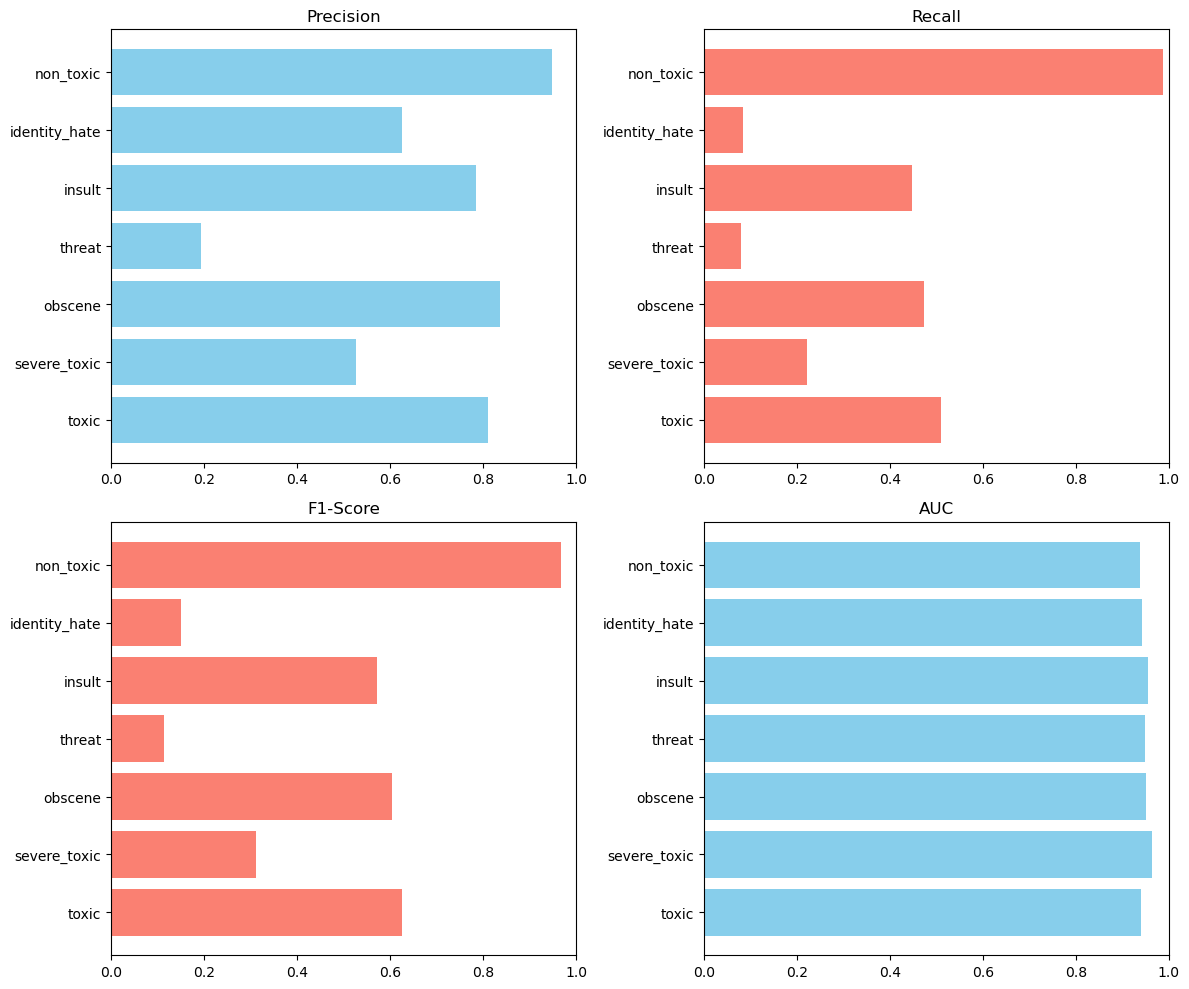

In [1]:
import matplotlib.pyplot as plt

# Define the labels and corresponding metrics based on your new scores
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
precision = [0.8104, 0.5259, 0.8354, 0.1935, 0.7844, 0.625, 0.9464]
recall = [0.5092, 0.2212, 0.4735, 0.0811, 0.4486, 0.0850, 0.9866]
f1_score = [0.6254, 0.3114, 0.6044, 0.1143, 0.5708, 0.1497, 0.9661]
auc = [0.9410, 0.9626, 0.9516, 0.9475, 0.9541, 0.9414, 0.9378]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot precision
axs[0, 0].barh(labels, precision, color='skyblue')
axs[0, 0].set_title('Precision')
axs[0, 0].set_xlim(0, 1)  # Set x-axis limit for better visualization

# Plot recall
axs[0, 1].barh(labels, recall, color='salmon')
axs[0, 1].set_title('Recall')
axs[0, 1].set_xlim(0, 1)  # Set x-axis limit for better visualization

# Plot F1-score
axs[1, 0].barh(labels, f1_score, color='salmon')
axs[1, 0].set_title('F1-Score')
axs[1, 0].set_xlim(0, 1)  # Set x-axis limit for better visualization

# Plot AUC
axs[1, 1].barh(labels, auc, color='skyblue')
axs[1, 1].set_title('AUC')
axs[1, 1].set_xlim(0, 1)  # Set x-axis limit for better visualization

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()